# Generative Algorithm for Multidimensional Unfolding

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import uproot
import awkward as ak
import hist
from hist import Hist

import numba

In [2]:
tree = uproot.open("data/DY_DUMP_4pi_GMC_Jan08_LD2.root:result_mc")

In [3]:
data = tree.arrays(["weight", "mass", "pT", "xF", "phi", "costh", "true_mass", "true_pT", "true_xF", "true_phi", "true_costh"],
                   "(fpga1==1) & (true_mass > 4.) & (true_mass < 8.0)",
                  library="pd")

data.shape

(5970312, 11)

In [4]:
data = data.dropna()

data.shape

(5970092, 11)

In [5]:
true_data = data[["weight", "true_mass"]].to_numpy()
reco_data = data[["weight", "mass"]].to_numpy()

In [6]:
from sklearn.model_selection import train_test_split

reco_train_1, reco_test_1, true_train_1, true_test_1 = train_test_split(reco_data, true_data, test_size=0.3, shuffle=True)
reco_train, reco_test, true_train, true_test = train_test_split(reco_test_1, true_test_1, test_size=0.3, shuffle=True)

In [7]:
print("*** train data : gen = {} & reco = {} ***".format(true_train.shape, reco_train.shape))
print("*** test data : gen = {} & reco = {} ***".format(true_test.shape, reco_test.shape))

*** train data : gen = (1253719, 2) & reco = (1253719, 2) ***
*** test data : gen = (537309, 2) & reco = (537309, 2) ***


In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 5000

dataset = TensorDataset(torch.Tensor(reco_train[:, 1:]), torch.Tensor(true_train[:, 1:]))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Generator(nn.Module):
    def __init__(self, dim: int=1):
        super(Generator, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(dim , 500),
            nn.BatchNorm1d(500),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(500, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc3 = nn.Linear(100, dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [10]:
class Discriminator(nn.Module):
    def __init__(self, dim: int=1):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(dim, 1000),
            nn.BatchNorm1d(1000),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1000, 500),
            nn.BatchNorm1d(500),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(500, 200),
            nn.BatchNorm1d(200),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc4 = nn.Sequential(
            nn.Linear(200, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

In [11]:
netD = Discriminator()
netG = Generator()

In [12]:
criterionD = nn.BCELoss()
criterionG = nn.MSELoss()

In [13]:
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.001)
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0001)

In [14]:
epochs = 50

lossesD, lossesG = [], []

real_label = 1.
fake_label = 0.

for epoch in range(epochs):
    for rec_data, gen_data in dataloader:
        
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        
        b_size = gen_data.shape[0]
        label = torch.full((b_size,), real_label, dtype=torch.float)
        
        output = netD(gen_data).view(-1)
        errD_real = criterionD(output, label)
        errD_real.backward()
        
        fake = netG(rec_data)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterionD(output, label)
        errD_fake.backward()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        # (2) Update G network: maximize log(D(G(z)))
        
        netG.zero_grad()
        label.fill_(real_label)
        
        output = netD(fake).view(-1)
        errG_clas = criterionD(output, label)
        errG_clas.backward()
        
        output = netG(rec_data)
        errG_reg = criterionG(output, gen_data)
        errG_reg.backward()
        
        errG = errG_clas + errG_reg
        
        optimizerG.step()
        
        lossesD.append(errD.item())
        lossesG.append(errG.item())

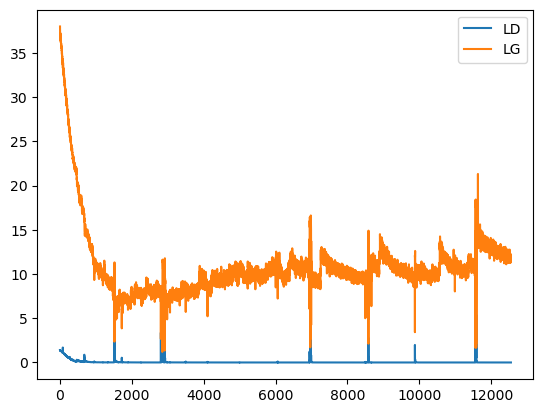

In [15]:
plt.plot(lossesD, label="LD")
plt.plot(lossesG, label="LG")
plt.legend()
plt.show()

In [16]:
with torch.no_grad():
    output = netG(torch.Tensor(reco_test[:, 1:]))

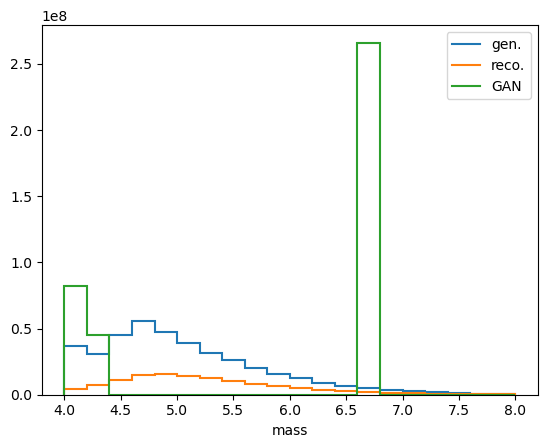

In [17]:
Hist(hist.axis.Regular(20, 4.0, 8.0, name="mass")).fill(true_test[:,1], weight=true_test[:,0]).plot(label="gen.")
Hist(hist.axis.Regular(20, 4.0, 8.0, name="mass")).fill(reco_test[reco_test[:, 0] > 0.0][:,1],
                                                        weight=reco_test[reco_test[:, 0] > 0.0][:,0]).plot(label="reco.")
Hist(hist.axis.Regular(20, 4.0, 8.0, name="mass")).fill(output[:,0], weight=reco_test[:,0]).plot(label="GAN")
plt.legend()
plt.show()